In [1]:
from functools import partial
from typing import Any, Callable, Optional
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


np.random.seed(42)


class LinearAgent:
    def __init__(
        self,
        *,
        t_min: float = -5,
        t_max: float = 5,
        n_samplers: int = 500,
        s_noise: float = 0.5
    ) -> None:
        self.range = (t_min, t_max)
        self.n_samplers = n_samplers
        self.s_noise = s_noise
    
    def prepare_figure(self) -> None:
        t_min, t_max = self.range
        plt.figure(figsize=(5, 4))
        plt.xlim(t_min - 2, t_max + 2)
        plt.ylim(self.data_y.min() - 5, self.data_y.max() + 5)
    
    def prepare_data(self, func: Callable[[np.ndarray], np.ndarray]) -> None:
        t_min, t_max = self.range
        self.data_x = np.linspace(t_min, t_max, self.n_samplers)
        self.plot_x = self.data_x.reshape(-1, 1)
        self.data_x += np.random.normal(scale=self.s_noise, size=self.n_samplers)
        self.data_y = func(self.data_x)
        self.data_y += np.random.normal(scale=self.s_noise, size=self.n_samplers)
        self.test_x = np.random.uniform(t_min, t_max, self.n_samplers // 2)
        self.test_y = func(self.test_x)

        self.data_x = self.data_x.reshape(-1, 1)
        self.test_x = self.test_x.reshape(-1, 1)

    def show_data(self, color: str = "blue", label: str = "data") -> None:
        plt.scatter(self.data_x[:, 0], self.data_y, c=color, label=label)
    
    def add_outliers(self, n_outliers: int = 0) -> None:
        n_outliers = n_outliers or self.n_samplers // 8
        self.data_x[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
        self.data_y[:n_outliers] = -3 + 5 * np.random.normal(size=n_outliers)
    
    def prepare_model(self, estimator: Any) -> Any:
        return estimator
    
    def test_model(
        self,
        name: str,
        estimator: Any,
        *,
        color: Optional[str] = None,
        linestyle: Optional[str] = None,
        linewidth: int = 3
    ) -> None:
        model = self.prepare_model(estimator)
        model.fit(self.data_x, self.data_y)
        mse = mean_squared_error(model.predict(self.test_x), self.test_y)
        y_plot = model.predict(self.plot_x)
        plt.plot(
            self.plot_x,
            y_plot,
            color=color,
            linestyle=linestyle,
            linewidth=linewidth,
            label="%s: error = %.3f" % (name, mse),
        )
    
    def add_info(self, title: str = "Modeling", loc: str = "best") -> None:
        plt.legend(
            loc=loc, frameon=False, prop=dict(size="x-small")
        )
        plt.title(title)


class PolyAgent(LinearAgent):
    def prepare_model(self, estimator: Any) -> Any:
        return make_pipeline(PolynomialFeatures(3), estimator)

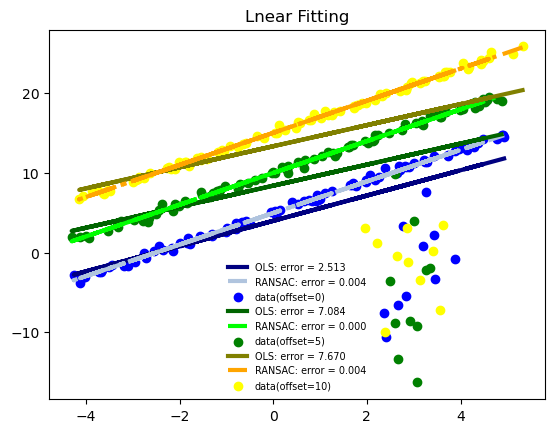

In [2]:
def linear_func(x, a, b):
    return a * x + b


a_true, b_true = 2, 5


agent = LinearAgent(
    n_samplers=100,
    t_min=-5,
    t_max=5,
    s_noise=0.3
)

colors = [
    ("blue", "navy", "lightsteelblue"),
    ("green", "darkgreen", "lime"),
    ("yellow", "olive", "orange")
]

for i, (data_color, ols_color, ransac_color) in zip(range(0, 15, 5), colors):
    agent.prepare_data(partial(linear_func, a=a_true, b=b_true + i))
    agent.add_outliers(10)
    agent.test_model(
        "OLS", LinearRegression(),
        color=ols_color, linestyle="-"
    )
    agent.test_model(
        "RANSAC", RANSACRegressor(),
        color=ransac_color, linestyle="-."
    )
    agent.show_data(data_color, f"data(offset={i})")
agent.add_info("Lnear Fitting")
plt.show()

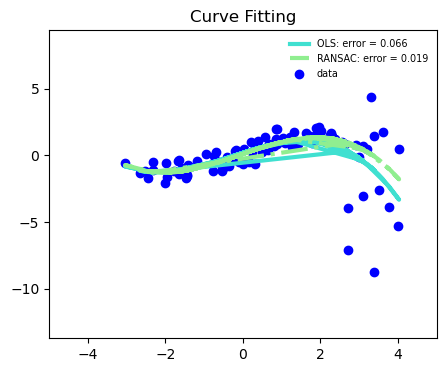

In [3]:
def curve_func(t, a, w1, b, w2):
    return a * np.sin(w1 * t) + b * np.sin(w2 * t)


a_true, w1_true, b_true, w2_true = 1, 1, .4, .5


agent = PolyAgent(
    n_samplers=100,
    t_min=-3,
    t_max=3,
    s_noise=0.5
)
agent.prepare_data(
    partial(curve_func, a=a_true, w1=w1_true, b=b_true, w2=w2_true)
)
agent.add_outliers(10)
agent.prepare_figure()
agent.test_model(
    "OLS", LinearRegression(),
    color="turquoise", linestyle="-"
)
agent.test_model(
    "RANSAC", RANSACRegressor(),
    color="lightgreen", linestyle="-."
)
agent.show_data()
agent.add_info("Curve Fitting")
plt.show()